# import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input, Conv1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import h5py
from tensorflow.keras import layers, models, optimizers
import joblib
import random
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# 로컬 모델 학습 코드

## 1D-CNN [지진 목록 데이터]

### 데이터 불러오기

In [ ]:
# 1. 데이터 준비 (지진 목록을 시계열로 변환)

gl_data = pd.read_csv('/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/gl_df.csv')
label = pd.read_csv('/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/label.csv')
gl_data.head()

# (1) 날짜 형식 통일
# 불러온 데이터가 문자열일 수 있으므로 datetime으로 강제 변환
if '발생일' in gl_data.columns:
    gl_data['발생일'] = pd.to_datetime(gl_data['발생일'])
    gl_data = gl_data.set_index('발생일')

if '발생일' in label.columns:
    label['발생일'] = pd.to_datetime(label['발생일'])
    label = label.set_index('발생일')
elif not isinstance(label.index, pd.DatetimeIndex):
    label.index = pd.to_datetime(label.index)

# (2) 데이터 정렬 (Feature와 Label 싱크 맞추기)
# label의 날짜를 기준으로 gl_data를 맞춥니다.
gl_features = gl_data.reindex(label.index)

# (3) 결측치 확인 및 채우기 (NaN 제거)
print("--- 결측치 점검 (채우기 전) ---")
print(gl_features.isnull().sum())

# 규모는 0.0으로, 나머지는 평균값으로 채움
gl_features['규모'] = gl_features['규모'].fillna(0.0)
for col in ['깊이(km)', '위도', '경도']:
    if col in gl_features.columns:
        # 혹시 평균이 NaN이면(데이터가 없으면) 0으로 채움
        mean_val = gl_features[col].mean()
        if pd.isna(mean_val): mean_val = 0.0
        gl_features[col] = gl_features[col].fillna(mean_val)

# label에도 NaN이 있는지 확인 (있으면 0으로)
label['규모'] = label['규모'].fillna(0.0)

--- 결측치 점검 (채우기 전) ---
규모        365
깊이(km)    365
위도        365
경도        365
dtype: int64


### 학습

In [ ]:
# 2. 윈도우 생성 (Sliding Window)
def create_dataset(gl_X, gl_y, window_size=3):
    gl_X_list, gl_y_mag_list = [], []

    for i in range(len(gl_X) - window_size):
        # gl_X: 과거 3일치의 데이터 (오늘 포함 or 미포함 설정 가능)
        gl_X_list.append(gl_X[i : i+window_size])

        # y: 내일(i+window_size)의 지진 규모 (label에서 가져옴)
        gl_y_mag_list.append(gl_y[i+window_size])

    return np.array(gl_X_list), np.array(gl_y_mag_list)

WINDOW_SIZE = 3

# 데이터 스케일링
scaler = StandardScaler()
gl_X_scaled = scaler.fit_transform(gl_features)

# y_values 정의
gl_y_values = label['규모'].values

# X는 스케일링된 데이터, y는 label의 규모 값 사용
gl_X_data, gl_y_mag = create_dataset(gl_X_scaled, gl_y_values, WINDOW_SIZE)

# 분류용 정답 생성 (규모 > 0 이면 발생 1, 아니면 0)
gl_y_class = (gl_y_mag > 0).astype(int)

# 데이터 분할 (Stratify 사용)
gl_X_train, gl_X_test, gl_yc_train, gl_yc_test, gl_ym_train, gl_ym_test = train_test_split(
    gl_X_data, gl_y_class, gl_y_mag,
    test_size=0.2,
    random_state=42,
    stratify=gl_y_class # 지진 발생 비율 맞춰서 분할
)

print(f"\n최종 데이터: Train {len(gl_X_train)}개 / Test {len(gl_X_test)}개")

# 1. 모델 초기화 (메모리 찌꺼기 제거)
tf.keras.backend.clear_session()

# 2. 초경량 안전 모델 정의
def build_stable_model(input_shape):
    inputs = Input(shape=input_shape)

    # [안전장치 1] L2 규제 적용 (가중치 폭주 방지)
    gl_x = Conv1D(filters=8, kernel_size=2, padding='same', activation='relu',
               kernel_regularizer=regularizers.l2(0.01))(inputs)
    gl_x = BatchNormalization()(gl_x) # 데이터 분포 안정화

    gl_x = GlobalAveragePooling1D()(gl_x)
    gl_x = Dropout(0.2)(gl_x)

    # 공통 은닉층
    gl_x = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01))(gl_x)

    # Head 1: 분류 (0 or 1)
    out_class = Dense(1, activation='sigmoid', name='classification')(gl_x)

    # Head 2: 회귀 (규모 예측) - ReLU 사용 (규모는 음수가 없으므로)
    out_mag = Dense(1, activation='relu', name='regression')(gl_x)

    gl_model = Model(inputs=inputs, outputs=[out_class, out_mag])
    return gl_model

gl_model = build_stable_model(input_shape=(WINDOW_SIZE, 4))

# [안전장치 2] Gradient Clipping & 낮은 학습률
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)

gl_model.compile(optimizer=optimizer,
              loss={'classification': 'binary_crossentropy', 'regression': 'mse'},
              loss_weights={'classification': 0.5, 'regression': 1.0}, # 회귀에 좀 더 집중
              metrics={'classification': 'accuracy', 'regression': 'mae'})

# 4. 학습 및 평가
print("\n학습 시작...")
history = gl_model.fit(
    gl_X_train, [gl_yc_train, gl_ym_train],
    validation_data=(gl_X_test, [gl_yc_test, gl_ym_test]),
    epochs=300,        # 천천히 오래 학습
    batch_size=4,      # 배치 사이즈 약간 키움
    verbose=0
)

# 특징 벡터 추출
FEATURE_LAYER_INDEX = -3

cnn_feature_extractor = Model(
    inputs=gl_model.input,
    outputs=gl_model.layers[FEATURE_LAYER_INDEX].output
)



최종 데이터: Train 289개 / Test 73개

학습 시작...


## smallGRU [지하수 데이터]

### 데이터 불러오기

In [ ]:
# 1. 데이터 로드
load_path = '/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/'
file_path = load_path + 'gru_dataset.npz'

if not os.path.exists(file_path):
    print("데이터 파일이 없습니다. 이전 단계의 데이터 저장 코드를 먼저 실행해주세요.")
else:
    gw_data = np.load(file_path)
    gw_X_raw = gw_data['X']
    gw_y_raw = gw_data['y']

    print(f"전체 데이터 형태: X={gw_X_raw.shape}, y={gw_y_raw.shape}")

전체 데이터 형태: X=(362, 3, 24), y=(362,)


### 학습

In [ ]:
# 분류용 정답 생성 (규모 > 0 이면 발생 1, 아니면 0)
gw_y_class = (gw_y_raw > 0).astype(int)

# y_raw와 y_class를 하나의 배열로 묶음
gw_y_combined = np.column_stack([gw_y_class, gw_y_raw])

# 시계열 순서를 유지하기 위해 train_test_split 대신 슬라이싱 사용
split_idx = int(len(gw_X_raw) * 0.8)
gw_X_train, gw_X_test = gw_X_raw[:split_idx], gw_X_raw[split_idx:]
gw_y_train_combined, gw_y_test_combined = gw_y_combined[:split_idx], gw_y_combined[split_idx:]

# 멀티태스크 학습을 위해 y 라벨을 분류와 회귀로 분리
gw_yc_train, gw_ym_train = gw_y_train_combined[:, 0], gw_y_train_combined[:, 1]
gw_yc_test, gw_ym_test = gw_y_test_combined[:, 0], gw_y_test_combined[:, 1]

# 2. 멀티태스크 GRU 모델 정의
def build_multitask_gru_model(input_shape):
    inputs = Input(shape=input_shape)

    # GRU 레이어 및 Dropout (특징 추출기 시작)
    gw_x = GRU(64, return_sequences=False)(inputs)
    gw_x = Dropout(0.3)(gw_x)

    # 공유 특징 벡터 추출층 (Shared Feature Vector Layer)
    shared_features = Dense(32, activation='relu')(gw_x)

    # Head 1: 분류 (Classification)
    out_class = Dense(1, activation='sigmoid', name='classification')(shared_features)

    # Head 2: 회귀 (Regression)
    out_mag = Dense(1, activation='linear', name='regression')(shared_features)

    gw_model = Model(inputs=inputs, outputs=[out_class, out_mag])
    return gw_model

# 모델 생성
gw_model = build_multitask_gru_model(input_shape=(gw_X_train.shape[1], gw_X_train.shape[2]))
# model.summary()

# 3. 모델 컴파일
gw_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'classification': 'binary_crossentropy', 'regression': 'mse'},
    # 손실 가중치를 조정 (분류: 0.5, 회귀: 1.0)
    loss_weights={'classification': 0.5, 'regression': 1.0},
    metrics={'classification': 'accuracy', 'regression': 'mae'}
)

# 4. 학습 시작
history = gw_model.fit(
    gw_X_train, [gw_yc_train, gw_ym_train],
    validation_data=(gw_X_test, [gw_yc_test, gw_ym_test]),
    epochs=100, # 기존 회귀 모델과 유사한 Epoch 사용
    batch_size=4,
    verbose=0
)

FEATURE_LAYER_INDEX = -3

gru_feature_extractor = Model(
    inputs=gw_model.input,
    outputs=gw_model.layers[FEATURE_LAYER_INDEX].output
)

## EQTransformer [지진파 데이터]

### 데이터 불러오기

In [ ]:
gl= pd.read_csv(
    '/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/gl.csv')

In [ ]:
# 1. 설정
RAW_H5_PATH = '/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/merged_seismic_data.h5'
SAVE_PATH = '/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/EQT_Multitask_Dataset_1.h5'

SAMPLING_RATE = 100.0
WINDOW_LEN = 6000
CENTER_OFFSET = 3000
START_TIME_UTC = pd.Timestamp("2017-10-31 15:00:00.008392", tz="UTC")

# 노이즈(비지진) 데이터 생성 개수 (지진 데이터 수와 비슷하게 설정)
NOISE_SAMPLES = 400

In [ ]:
import pandas as pd

# 2. 데이터셋 생성 함수
if os.path.exists(SAVE_PATH):
    os.remove(SAVE_PATH)

print("데이터셋 재생성 시작 (지진 + 노이즈 + 규모)")

# Convert 'p_arrival_utc' and 's_arrival_utc' to datetime objects
gl['p_arrival_utc'] = pd.to_datetime(gl['p_arrival_utc'])
gl['s_arrival_utc'] = pd.to_datetime(gl['s_arrival_utc'])

valid_events = gl.dropna(subset=['p_arrival_utc', 's_arrival_utc'])
earthquake_times = [] # 노이즈 생성 시 겹치지 않게 하기 위해 저장

try:
    with h5py.File(RAW_H5_PATH, 'r') as f_raw, h5py.File(SAVE_PATH, 'w') as f_train:
        raw_data = f_raw['data']
        total_samples = raw_data.shape[0]

        # 저장할 데이터셋 (X: 파형, y_class: 발생여부, y_mag: 규모)
        dset_X = f_train.create_dataset('X', shape=(0, 6000, 3), maxshape=(None, 6000, 3), dtype='float32')
        dset_y_class = f_train.create_dataset('y_class', shape=(0, 1), maxshape=(None, 1), dtype='float32')
        dset_y_mag = f_train.create_dataset('y_mag', shape=(0, 1), maxshape=(None, 1), dtype='float32')

        count = 0

        # 지진 데이터 저장
        for idx, row in valid_events.iterrows():
            p_time = row['p_arrival_utc']
            magnitude = row['규모'] # 규모 정보 가져오기

            elapsed = (p_time - START_TIME_UTC).total_seconds()
            if elapsed < 0: continue

            p_global = int(elapsed * SAMPLING_RATE)
            earthquake_times.append(p_global) # 위치 기록

            start_idx = p_global - CENTER_OFFSET
            end_idx = start_idx + WINDOW_LEN

            if start_idx < 0 or end_idx > total_samples: continue

            # X: 파형 로드 및 정규화
            x_win = raw_data[start_idx : end_idx]
            if np.max(np.abs(x_win)) > 0: x_win /= np.max(np.abs(x_win))

            # 저장 (Class=1, Mag=실제규모)
            n = dset_X.shape[0]
            dset_X.resize(n+1, axis=0); dset_X[n] = x_win
            dset_y_class.resize(n+1, axis=0); dset_y_class[n] = 1.0
            dset_y_mag.resize(n+1, axis=0); dset_y_mag[n] = magnitude

            count += 1

        print(f"지진 데이터 {count}개 저장 완료.")

        # 노이즈(비지진) 데이터 생성
        noise_count = 0
        while noise_count < NOISE_SAMPLES:
            # 랜덤한 시작 위치 선정
            rand_idx = random.randint(0, total_samples - WINDOW_LEN)

            # 지진 발생 구간과 겹치는지 확인 (겹치면 스킵)
            is_overlap = False
            for eq_idx in earthquake_times:
                if abs(rand_idx + CENTER_OFFSET - eq_idx) < WINDOW_LEN: # 겹침 판정
                    is_overlap = True
                    break
            if is_overlap: continue

            # X: 파형 로드 및 정규화
            x_win = raw_data[rand_idx : rand_idx + WINDOW_LEN]
            if np.max(np.abs(x_win)) > 0: x_win /= np.max(np.abs(x_win))

            # 저장 (Class=0, Mag=0)
            n = dset_X.shape[0]
            dset_X.resize(n+1, axis=0); dset_X[n] = x_win
            dset_y_class.resize(n+1, axis=0); dset_y_class[n] = 0.0
            dset_y_mag.resize(n+1, axis=0); dset_y_mag[n] = 0.0

            noise_count += 1

        print(f"노이즈 데이터 {noise_count}개 저장 완료.")
        print(f"총 데이터셋 크기: {dset_X.shape[0]}개")

except Exception as e:
    print(f"에러 발생: {e}")

🔄 데이터셋 재생성 시작 (지진 + 노이즈 + 규모)...
지진 데이터 417개 저장 완료.
노이즈 데이터 400개 저장 완료.
총 데이터셋 크기: 817개


In [ ]:
# 1. 데이터 로드
LOAD_PATH = '/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/EQT_Multitask_Dataset_1.h5'

with h5py.File(LOAD_PATH, 'r') as f:
    gs_X_all = f['X'][:]
    gs_y_class_all = f['y_class'][:]
    gs_y_mag_all = f['y_mag'][:]

print(f"데이터 로드 완료: X {gs_X_all.shape}")

데이터 로드 완료: X (817, 6000, 3)


### 학습

In [ ]:
# 2. Train/Test 분리 (랜덤 셔플)

# 오류 방지
if len(gs_X_all) == 0:
    print("경고: gs_X_all 데이터셋이 비어 있습니다. 모델 학습을 건너뜁니다. HDF5 파일을 확인해 주세요.")
else:
    indices = np.arange(len(gs_X_all))
    np.random.shuffle(indices)

    split_idx = int(len(gs_X_all) * 0.8)
    train_idx, test_idx = indices[:split_idx], indices[split_idx:]

    gs_X_train, gs_X_test = gs_X_all[train_idx], gs_X_all[test_idx]
    gs_y_c_train, gs_y_c_test = gs_y_class_all[train_idx], gs_y_class_all[test_idx]
    gs_y_m_train, gs_y_m_test = gs_y_mag_all[train_idx], gs_y_mag_all[test_idx]

    # 3. 모델 정의 (EQTransformer 스타일 Simplified)
    def build_eqt_multitask_model(input_shape=(6000, 3)):
        inputs = layers.Input(shape=input_shape)

        # [Encoder] 1D CNN Layers
        gs_x = layers.Conv1D(8, 11, padding='same', activation='relu')(inputs)
        gs_x = layers.MaxPooling1D(2)(gs_x)
        gs_x = layers.Conv1D(16, 9, padding='same', activation='relu')(gs_x)
        gs_x = layers.MaxPooling1D(2)(gs_x)
        gs_x = layers.Conv1D(32, 7, padding='same', activation='relu')(gs_x)
        gs_x = layers.MaxPooling1D(2)(gs_x)

        # [Attention] Transformer Block
        # CNN 출력을 시퀀스로 간주하여 Self-Attention 적용
        gs_x = layers.LayerNormalization(epsilon=1e-6)(gs_x)
        # Multi-head Attention
        att_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(gs_x, gs_x)
        gs_x = layers.Add()([gs_x, att_output]) # Residual Connection
        gs_x = layers.LayerNormalization(epsilon=1e-6)(gs_x)

        # [Global Pooling] 시계열 정보를 하나로 압축
        gs_x = layers.GlobalAveragePooling1D()(gs_x)
        gs_x = layers.Dropout(0.3)(gs_x)

        # [Head 1] 지진 발생 여부 (이진 분류)
        out_class = layers.Dense(16, activation='relu')(gs_x)
        out_class = layers.Dense(1, activation='sigmoid', name='classification')(out_class)

        # [Head 2] 지진 규모 예측 (회귀)
        out_mag = layers.Dense(16, activation='relu')(gs_x)
        out_mag = layers.Dense(1, activation='linear', name='regression')(out_mag)

        gs_model = models.Model(inputs=inputs, outputs=[out_class, out_mag])
        return gs_model

    # 4. 모델 컴파일
    gs_model = build_eqt_multitask_model()
    gs_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss={
            'classification': 'binary_crossentropy', # 분류 손실함수
            'regression': 'mse'                      # 회귀 손실함수
        },
        loss_weights={
            'classification': 1.0, # 두 태스크의 가중치 조절
            'regression': 1.0
        },
        metrics={
            'classification': 'accuracy',
            'regression': 'mae'
        }
    )

    gs_model.summary()

    # 5. 학습 시작
    print("\n모델 학습 시작")
    history = gs_model.fit(
        gs_X_train, [gs_y_c_train, gs_y_m_train],
        validation_data=(gs_X_test, [gs_y_c_test, gs_y_m_test]),
        epochs=30, # 데이터가 많아졌으므로 Epoch 조정
        batch_size=32,
        verbose=1
    )

    # 6. 특징 벡터 추출
    FEATURE_LAYER_INDEX = -6

    eqt_feature_extractor = Model(
        inputs=gs_model.input,
        outputs=gs_model.layers[FEATURE_LAYER_INDEX].output
    )

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 6000, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 6000, 8)   │        272 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 3000, 8)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 3000, 16)  │      1,168 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1500, 16)  │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1500, 32)  │      3,616 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 750, 32)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 750, 32)   │         64 │ max_pooling1d_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 750, 32)   │     16,800 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 750, 32)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 750, 32)   │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         17 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 1)         │         17 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,074 (90.13 KB)

 Trainable params: 23,074 (90.13 KB)

 Non-trainable params: 0 (0.00 B)


모델 학습 시작...
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step - classification_accuracy: 0.6184 - classification_loss: 0.6600 - loss: 2.9250 - regression_loss: 2.2626 - regression_mae: 1.1189 - val_classification_accuracy: 0.9329 - val_classification_loss: 0.4355 - val_loss: 0.8416 - val_regression_loss: 0.4368 - val_regression_mae: 0.5524
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - classification_accuracy: 0.8880 - classification_loss: 0.4217 - loss: 0.7785 - regression_loss: 0.3558 - regression_mae: 0.4709 - val_classification_accuracy: 0.9878 - val_classification_loss: 0.2010 - val_loss: 0.3716 - val_regression_loss: 0.1600 - val_regression_mae: 0.3013
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - classification_accuracy: 0.9725 - classification_loss: 0.2161 - loss: 0.4734 - regression_loss: 0.2570 - regression_mae: 0.3674 - val_classification_accuracy: 0.9878 - val_classification_loss: 0.1042 - val_loss: 0.2508 - val_regression_loss: 0.1473 - val_regression_mae:

## 특징 벡터 확인

In [ ]:
print("=====1D-CNN 특징 벡터=====")
print(cnn_feature_extractor.output_shape)
print("=====small GRU 특징 벡터=====")
print(gru_feature_extractor.output_shape)
print("=====EQTransformer 특징 벡터=====")
print(eqt_feature_extractor.output_shape)

=====1D-CNN 특징 벡터=====
(None, 8)
=====small GRU 특징 벡터=====
(None, 32)
=====EQTransformer 특징 벡터=====
(None, 32)


# UMIS

지진 예측 (이진분류)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import numpy as np

# 1. 하이퍼파라미터 설정
GLOBAL_DIM = 64  # Adapter를 통과한 후의 차원
UMIS_DIM = 32    # 최종 공통 임베딩 차원 - 서버에서 평균낼 차원

# 2. UMIS 모델 정의
class UMIS_Federated_Model(Model):
    def __init__(self, local_feature_extractor, local_output_dim, global_dim=GLOBAL_DIM, umis_dim=UMIS_DIM):
        super(UMIS_Federated_Model, self).__init__()

        # (1) 로컬 인코더
        self.encoder = local_feature_extractor
        # 인코더도 같이 학습시킬지 여부 (True: 미세조정, False: 고정)
        # self.encoder.trainable = True
        #self.encoder.trainable = False #수정

        # (2) 로컬 어댑터 + BN
        self.adapter = layers.Dense(global_dim, activation='relu', name='local_adapter')
        self.bn = layers.BatchNormalization(name='adapter_bn')
        self.act = layers.Activation('relu')

        # (3) UMIS Projection (Global Dim -> UMIS Dim)
        self.projection = layers.Dense(umis_dim, activation='relu', name='umis_projection')

        # (4) 예측 헤드
        self.classifier = layers.Dense(1, activation='sigmoid', name='prediction_head')

    def call(self, inputs):
        # 1. 특징 추출
        x = self.encoder(inputs)

        # 2. 차원 맞추기 (Adapter)
        x = self.adapter(x)

        # 3. 공통 공간 투영 (Projection)
        z = self.projection(x)

        # 4. 최종 예측
        output = self.classifier(z)
        return output

In [ ]:
# 기존 코드의 데이터 변수명 매핑 (코드_통합 파일 기준)
# CNN: gl_X_train (입력), gl_yc_train (분류 라벨)
# GRU: gw_X_train (입력), gw_yc_train (분류 라벨)
# EQT: gs_X_train (입력), gs_y_c_train (분류 라벨)

# 모델 생성
print("Client 1 (CNN) 생성 중")
client_cnn = UMIS_Federated_Model(cnn_feature_extractor, local_output_dim=8)
client_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Client 2 (GRU) 생성 중")
client_gru = UMIS_Federated_Model(gru_feature_extractor, local_output_dim=32)
client_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Client 3 (EQT) 생성 중")
client_eqt = UMIS_Federated_Model(eqt_feature_extractor, local_output_dim=32)
client_eqt.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 관리 리스트 생성
clients = [client_cnn, client_gru, client_eqt]
client_names = ["1D-CNN", "smallGRU", "EQTransformer"]

# 데이터 리스트 생성
client_data = [
    (gl_X_train, gl_yc_train),
    (gw_X_train, gw_yc_train),
    (gs_X_train, gs_y_c_train)]

print("모든 클라이언트 모델 준비 완료")

🔄 모델 재설정: 인코더 학습 허용(Unfreeze) + 차등 학습률 적용...
✅ 모든 클라이언트 모델 준비 완료


지진 규모 예측 (회귀)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model

# 2. UMIS 모델 정의
class UMIS_Federated_Regressor(Model):
    def __init__(self, local_feature_extractor, local_output_dim, global_dim=64, umis_dim=32):
        super(UMIS_Federated_Regressor, self).__init__()

        # (1) 로컬 인코더
        self.encoder = local_feature_extractor
        #self.encoder.trainable = True
        self.encoder.trainable = False

        # (2) 로컬 어댑터 + BN
        self.adapter = layers.Dense(global_dim, activation='linear', name='local_adapter')
        self.bn = layers.BatchNormalization(name='adapter_bn')
        self.act = layers.Activation('relu')

        # (3) UMIS Projection
        self.projection = layers.Dense(umis_dim, activation='relu', name='umis_projection')

        # (4) 예측 헤드
        self.regressor = layers.Dense(1, activation='linear', name='prediction_head')

    def call(self, inputs):
        x = self.encoder(inputs)

        x = self.adapter(x)
        x = self.bn(x)
        x = self.act(x)

        z = self.projection(x)
        output = self.regressor(z)
        return output

In [ ]:
# 1. 모델 재생성
print("회귀 모델 생성 중 (Loss: MSE, Metric: MAE)")

UNIFIED_LR = 0.0001

# Client 1: CNN
cnn_feature_extractor.trainable = False #True->False로 수정함
client_cnn = UMIS_Federated_Regressor(cnn_feature_extractor, local_output_dim=8)
client_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=UNIFIED_LR, clipnorm=1.0),
                   loss='mse', metrics=['mae'])

# Client 2: GRU
gru_feature_extractor.trainable = False #True->False로 수정함
client_gru = UMIS_Federated_Regressor(gru_feature_extractor, local_output_dim=32)
client_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=UNIFIED_LR, clipnorm=1.0),
                   loss='mse', metrics=['mae'])

# Client 3: EQT
eqt_feature_extractor.trainable = False #True->False로 수정함
client_eqt = UMIS_Federated_Regressor(eqt_feature_extractor, local_output_dim=32)
client_eqt.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=UNIFIED_LR, clipnorm=1.0),
                   loss='mse', metrics=['mae'])

clients = [client_cnn, client_gru, client_eqt]
client_names = ["1D-CNN", "smallGRU", "EQTransformer"]

🔄 회귀 모델 생성 중 (Loss: MSE, Metric: MAE)...


# 연합학습

In [ ]:
def fedavg_shared_layers(weights_list, sample_counts):
    """
    weights_list: 각 클라이언트에서 추출한 [Projection_W, Projection_b, Head_W, Head_b] 리스트들의 리스트
    sample_counts: 데이터 개수 리스트
    """
    total_samples = sum(sample_counts)

    # 결과를 담을 리스트 (첫 번째 클라이언트의 가중치 모양으로 0 초기화)
    # weights_list[0] 은 [w1, b1, w2, b2] 형태의 numpy 배열 리스트임
    new_weights = [np.zeros_like(w) for w in weights_list[0]]

    for i, client_w_list in enumerate(weights_list):
        n = sample_counts[i]
        ratio = n / total_samples

        # 각 레이어의 가중치(w, b)를 순회하며 더함
        for layer_idx, w_arr in enumerate(client_w_list):
            new_weights[layer_idx] += w_arr * ratio

    return new_weights

이진분류

In [ ]:
import matplotlib.pyplot as plt

# 1. 테스트 데이터 준비 (평가용)
client_test_data = [
    (gl_X_test, gl_yc_test),   # Client 1: CNN (지진 목록)
    (gw_X_test, gw_yc_test),   # Client 2: GRU (지하수)
    (gs_X_test, gs_y_c_test)   # Client 3: EQT (지진파)
]

# 결과 저장을 위한 리스트
history_acc = [[], [], []]   # 클라이언트별 정확도 기록
history_loss = [[], [], []]  # 클라이언트별 Loss 기록

# 2. 모델 초기화 (Build) - 이전 단계와 동일
for idx, model in enumerate(clients):
    X_sample = client_data[idx][0][:5]
    _ = model(X_sample)

# 3. 연합 학습 시작
NUM_ROUNDS = 20
EPOCHS_PER_ROUND = 5

# 초기 글로벌 가중치 설정
initial_proj = clients[0].get_layer('umis_projection').get_weights()
initial_head = clients[0].get_layer('prediction_head').get_weights()
global_shared_weights = initial_proj + initial_head

for rnd in range(1, NUM_ROUNDS + 1):
    print(f"\n==== Round {rnd} ====")

    # 글로벌 가중치 배포
    proj_len = len(initial_proj)
    w_proj_global = global_shared_weights[:proj_len]
    w_head_global = global_shared_weights[proj_len:]

    for client_model in clients:
        client_model.get_layer('umis_projection').set_weights(w_proj_global)
        client_model.get_layer('prediction_head').set_weights(w_head_global)

    # 로컬 학습 및 가중치 수집
    collected_weights = []
    sample_counts = []

    for idx, client_model in enumerate(clients):
        X_train, y_train = client_data[idx]

        # (1) 로컬 학습
        client_model.fit(X_train, y_train, epochs=EPOCHS_PER_ROUND, batch_size=16, verbose=0)

        # (2) 가중치 추출
        w_proj = client_model.get_layer('umis_projection').get_weights()
        w_head = client_model.get_layer('prediction_head').get_weights()
        collected_weights.append(w_proj + w_head)
        sample_counts.append(len(X_train))

    # 서버 집계 (FedAvg)
    global_shared_weights = fedavg_shared_layers(collected_weights, sample_counts)

    # 성능 평가 (Evaluation) 단계
    w_proj_new = global_shared_weights[:proj_len]
    w_head_new = global_shared_weights[proj_len:]

    for idx, client_model in enumerate(clients):
        # 최신 글로벌 가중치 적용
        client_model.get_layer('umis_projection').set_weights(w_proj_new)
        client_model.get_layer('prediction_head').set_weights(w_head_new)

        # 테스트 데이터로 평가
        X_test, y_test = client_test_data[idx]

        # evaluate()는 [loss, accuracy]를 반환합니다.
        results = client_model.evaluate(X_test, y_test, verbose=0)

        loss_val = results[0]
        acc_val = results[1]

        # 기록 저장
        history_loss[idx].append(loss_val)
        history_acc[idx].append(acc_val)

        print(f"\n   [{client_names[idx]}] Accuracy: {acc_val*100:.2f}% | Loss: {loss_val:.4f}", end="")
    print("\n")

    avg_loss = sum(history_loss[i][-1] for i in range(len(clients))) / len(clients)
    avg_acc = sum(history_acc[i][-1] for i in range(len(clients))) / len(clients)

    print("-" * 40)
    print(f"[Round {rnd} Global Score] Average Accuracy: {avg_acc*100:.2f}% | Average Loss: {avg_loss:.4f}")
    print("-" * 40)


==== Round 1 ====

   [1D-CNN] Accuracy: 15.08% | Loss: 0.1321
   [smallGRU] Accuracy: 47.77% | Loss: 0.3512
   [EQTransformer] Accuracy: 25.16% | Loss: 0.0953

----------------------------------------
[Round 1 Global Score] Average Accuracy: 29.34% | Average Loss: 0.1928
----------------------------------------

==== Round 2 ====

   [1D-CNN] Accuracy: 15.95% | Loss: 0.1295
   [smallGRU] Accuracy: 46.53% | Loss: 0.3073
   [EQTransformer] Accuracy: 7.62% | Loss: 0.0253

----------------------------------------
[Round 2 Global Score] Average Accuracy: 23.37% | Average Loss: 0.1540
----------------------------------------

==== Round 3 ====

   [1D-CNN] Accuracy: 16.49% | Loss: 0.1279
   [smallGRU] Accuracy: 45.28% | Loss: 0.2847
   [EQTransformer] Accuracy: 4.89% | Loss: 0.0249

----------------------------------------
[Round 3 Global Score] Average Accuracy: 22.22% | Average Loss: 0.1458
----------------------------------------

==== Round 4 ====

   [1D-CNN] Accuracy: 16.94% | Loss: 

회귀

✅ 데이터셋이 '규모 예측용'으로 교체되었습니다.
✅ 회귀 모델 준비 완료!

🚀 규모 예측 연합 학습 시작

==== 🔄 Round 1 ====
📊 성능 평가 (MAE: 낮을수록 좋음)...
   [1D-CNN] MAE: 0.2117 (오차: ±0.21)
   [smallGRU] MAE: 1.1154 (오차: ±1.12)
   [EQTransformer] MAE: 0.8106 (오차: ±0.81)
🌍 [Global Score] Avg Loss(MSE): 1.4157 | Avg MAE: 0.7126

==== 🔄 Round 2 ====
📊 성능 평가 (MAE: 낮을수록 좋음)...
   [1D-CNN] MAE: 0.2235 (오차: ±0.22)
   [smallGRU] MAE: 1.0792 (오차: ±1.08)
   [EQTransformer] MAE: 0.2909 (오차: ±0.29)
🌍 [Global Score] Avg Loss(MSE): 1.0364 | Avg MAE: 0.5312

==== 🔄 Round 3 ====
📊 성능 평가 (MAE: 낮을수록 좋음)...
   [1D-CNN] MAE: 0.2278 (오차: ±0.23)
   [smallGRU] MAE: 1.0789 (오차: ±1.08)
   [EQTransformer] MAE: 0.1935 (오차: ±0.19)
🌍 [Global Score] Avg Loss(MSE): 0.9881 | Avg MAE: 0.5001

==== 🔄 Round 4 ====
📊 성능 평가 (MAE: 낮을수록 좋음)...
   [1D-CNN] MAE: 0.2307 (오차: ±0.23)
   [smallGRU] MAE: 1.0781 (오차: ±1.08)
   [EQTransformer] MAE: 0.1905 (오차: ±0.19)
🌍 [Global Score] Avg Loss(MSE): 0.9773 | Avg MAE: 0.4997

==== 🔄 Round 5 ====
📊 성능 평가 (MAE: 낮을수록 좋음)...
   [1D-C

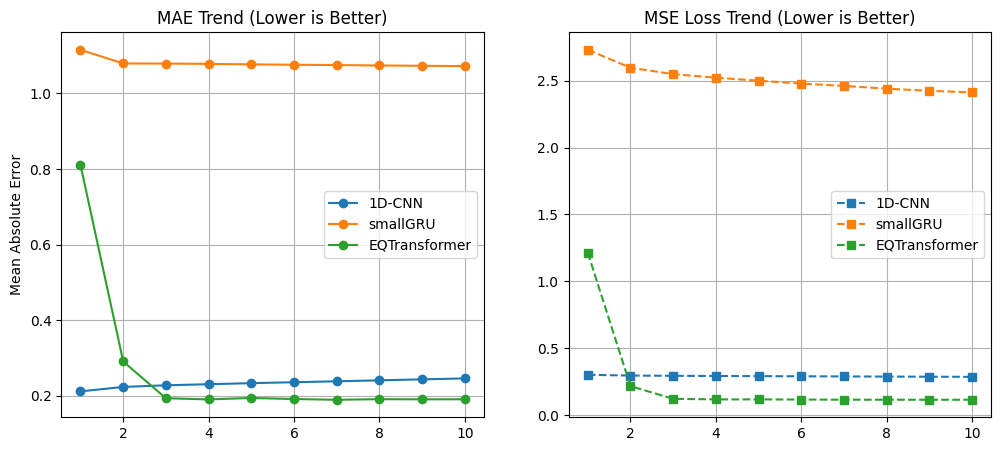

In [ ]:
client_data_reg = [
    (gl_X_train, gl_ym_train),   # CNN: 규모 데이터
    (gw_X_train, gw_ym_train),   # GRU: 규모 데이터
    (gs_X_train, gs_y_m_train)   # EQT: 규모 데이터
]

client_test_data_reg = [
    (gl_X_test, gl_ym_test),
    (gw_X_test, gw_ym_test),
    (gs_X_test, gs_y_m_test)
]

print("데이터셋이 '규모 예측용'으로 교체되었습니다.")

# 초기화 (Build)
for idx, model in enumerate(clients):
    X_sample = client_data_reg[idx][0][:32]
    _ = model(X_sample)

print("회귀 모델 준비 완료\n")

# 2. 연합 학습 시작 (회귀 버전)
NUM_ROUNDS = 10
EPOCHS_PER_ROUND = 3

print(f"규모 예측 연합 학습 시작")

initial_proj = clients[0].get_layer('umis_projection').get_weights()
initial_head = clients[0].get_layer('prediction_head').get_weights()
global_shared_weights = initial_proj + initial_head

# 기록용 (Acc 대신 MAE 저장)
history_mae = [[], [], []]
history_loss = [[], [], []]

for rnd in range(1, NUM_ROUNDS + 1):
    print(f"\n==== 🔄 Round {rnd} ====")

    # [A] 배포
    proj_len = len(initial_proj)
    w_proj_global = global_shared_weights[:proj_len]
    w_head_global = global_shared_weights[proj_len:]

    for client_model in clients:
        client_model.get_layer('umis_projection').set_weights(w_proj_global)
        client_model.get_layer('prediction_head').set_weights(w_head_global)

    # [B] 로컬 학습
    collected_weights = []
    sample_counts = []

    for idx, client_model in enumerate(clients):
        X_train, y_train = client_data_reg[idx]

        client_model.fit(X_train, y_train, epochs=EPOCHS_PER_ROUND, batch_size=32, verbose=0)

        w_proj = client_model.get_layer('umis_projection').get_weights()
        w_head = client_model.get_layer('prediction_head').get_weights()
        collected_weights.append(w_proj + w_head)
        sample_counts.append(len(X_train))

    # [C] 집계 (FedAvg) - 회귀에서도 가중치 평균 원리는 동일
    global_shared_weights = fedavg_shared_layers(collected_weights, sample_counts)

    # [D] 평가
    print("성능 평가 (MAE: 낮을수록 좋음)", end="")
    w_proj_new = global_shared_weights[:proj_len]
    w_head_new = global_shared_weights[proj_len:]

    round_losses = []
    round_maes = []

    for idx, client_model in enumerate(clients):
        client_model.get_layer('umis_projection').set_weights(w_proj_new)
        client_model.get_layer('prediction_head').set_weights(w_head_new)

        X_test, y_test = client_test_data_reg[idx]
        results = client_model.evaluate(X_test, y_test, verbose=0)

        # Regression evaluate returns [loss(mse), mae]
        loss_val, mae_val = results[0], results[1]

        round_losses.append(loss_val)
        round_maes.append(mae_val)
        history_loss[idx].append(loss_val)
        history_mae[idx].append(mae_val)

        print(f"\n   [{client_names[idx]}] MAE: {mae_val:.4f} (오차: ±{mae_val:.2f})", end="")

    avg_loss = sum(round_losses) / len(clients)
    avg_mae = sum(round_maes) / len(clients)
    print(f"\n [Global Score] Avg Loss(MSE): {avg_loss:.4f} | Avg MAE: {avg_mae:.4f}")

print("\n 학습 종료!")

# 그래프 그리기 (MAE & MSE)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for idx, name in enumerate(client_names):
    plt.plot(range(1, NUM_ROUNDS+1), history_mae[idx], marker='o', label=name)
plt.title('MAE Trend (Lower is Better)')
plt.ylabel('Mean Absolute Error')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
for idx, name in enumerate(client_names):
    plt.plot(range(1, NUM_ROUNDS+1), history_loss[idx], marker='s', linestyle='--', label=name)
plt.title('MSE Loss Trend (Lower is Better)')
plt.legend(); plt.grid(True)
plt.show()